In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense,LSTM,Conv2D, BatchNormalization,Flatten, MaxPooling2D
from keras.layers import Conv2DTranspose,Concatenate,UpSampling2D,Cropping2D
from keras.layers import Input, Lambda, Reshape, Dropout, Activation

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Dotenv
from dotenv import dotenv_values
# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_plot import *
from utils.utils_unet import *
from utils.utils_resnet import *

In [2]:
# Define paths
config = dotenv_values(".env")
PATH_ERA5 = config['PATH_ERA5']
PATH_EOBS = config['PATH_EOBS']


In [3]:
# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
# train -test (80/20 of total yy), train-> split 80/20 for validation
#YY_TRAIN = [1979, 2011] # 2005-2011 for validation
#YY_VAL = [2005,2011]
#YY_TEST = [2012, 2020]
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]
YY_VALID = 2005
LEVELS = [500, 850, 1000]
G = 9.80665 
LONS_INPUT = [-25, 30]
LATS_INPUT = [30, 75]
LONS_PREC = [-25, 30]
LATS_PREC = [30, 75]

PRECIP_DATA = 'ERA5' # Options: ERA5, E-OBS
PRECIP_XTRM = 0.95 # Percentile (threshold) for the extremes

# Data loading

### Load precipitation

In [4]:
# Load precipitation
if PRECIP_DATA == 'ERA5':
    pr = get_nc_data(PATH_ERA5 + '/precipitation/day_grid1/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.tp
elif PRECIP_DATA in ['E-OBS', 'EOBS']:
    pr = get_nc_data(PATH_EOBS + '/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.rr
    pr = pr.coarsen(lon=5, lat=5, boundary="trim").mean()
    pr = pr.fillna(0) # Over the seas. Not optimal...
else:
    raise('Precipitation data not well defined')

Extracting data for the period 1979-01-01 - 2020-12-31


In [5]:
# Define extremes
pr95 = precip_exceedance_xarray(pr, PRECIP_XTRM)

### Load predictors

In [6]:
# define paths for the variables used
l_paths = ['/geopotential/grid1/','/temperature/grid1/','/relative_humidity/day_grid1/',
              '/U_wind/day_grid1/','/V_wind/day_grid1/','/total_column_water/day_grid1/']
v_vars = ['z','t2m','rh','u850','v850','tpcw']

In [7]:
list_vars = load_data(v_vars, l_paths, G, PATH_ERA5, DATE_START, DATE_END, LONS_INPUT, LATS_INPUT, LEVELS)

Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31


In [8]:
datasets = list_vars

In [9]:
# checking dimensions
print('dimension of pr:',pr.dims)
print('dimension of z',datasets[0].dims)
print('dimension of t2m:',datasets[1].dims)
print('dimension of rh:',datasets[2].dims)
print('dimension of u:',datasets[3].dims)
print('dimension of v:',datasets[4].dims)
print('dimension of tw:',datasets[5].dims)

dimension of pr: ('time', 'lat', 'lon')
dimension of z Frozen({'time': 15341, 'lon': 56, 'lat': 46, 'level': 3})
dimension of t2m: Frozen({'time': 15341, 'lon': 56, 'lat': 46})
dimension of rh: Frozen({'time': 15341, 'lon': 56, 'lat': 46, 'level': 3})
dimension of u: Frozen({'time': 15341, 'lon': 56, 'lat': 46})
dimension of v: Frozen({'time': 15341, 'lon': 56, 'lat': 46})
dimension of tw: Frozen({'time': 15341, 'lon': 56, 'lat': 46})


In [10]:
# Then we need a dictionary for all the variables and levels we want to extract from the dataset
#dic = OrderedDict({'z': 3, 'T2MMEAN':None, 'r':3})
dic = {
     'z': LEVELS,
      'T2MMEAN': None,
      'r': LEVELS,
      'u': None,
      'v': None,
      'tcwv':None}

In [11]:
# Check if all have the same latitude order
for idat in range(0, len(datasets)):
    # Invert lat axis if needed
    if datasets[idat].lat[0].values < datasets[idat].lat[1].values:
        print('change lat order', idat)
        datasets[idat] = datasets[idat].reindex(lat=list(reversed(datasets[idat].lat)))

change lat order 0
change lat order 1


In [12]:
ds = xr.merge(datasets)

In [13]:
BATCH_SIZE=64 # try increase, decrease it

In [14]:
# Split into training and test, then I will use DataGenerator class to get the validation
ds_train = ds.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
ds_test = ds.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                            '{}-12-31'.format(YY_TEST[1])))

dy_train = pr95.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
dy_test = pr95.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                             '{}-12-31'.format(YY_TEST[1])))

In [15]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = MyDataGenerator(ds_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                dy_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')), dic, batch_size= BATCH_SIZE, load=True)

Loading data into RAM


In [16]:
# Create a validation. Use the train mean and std for validation as well. And suffle
dg_val = MyDataGenerator(ds_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                dy_train.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')), dic, batch_size=BATCH_SIZE,  mean=dg_train.mean, std=dg_train.std, load=True)

Loading data into RAM


In [17]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = MyDataGenerator(ds_test, dy_test, dic, batch_size=BATCH_SIZE, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


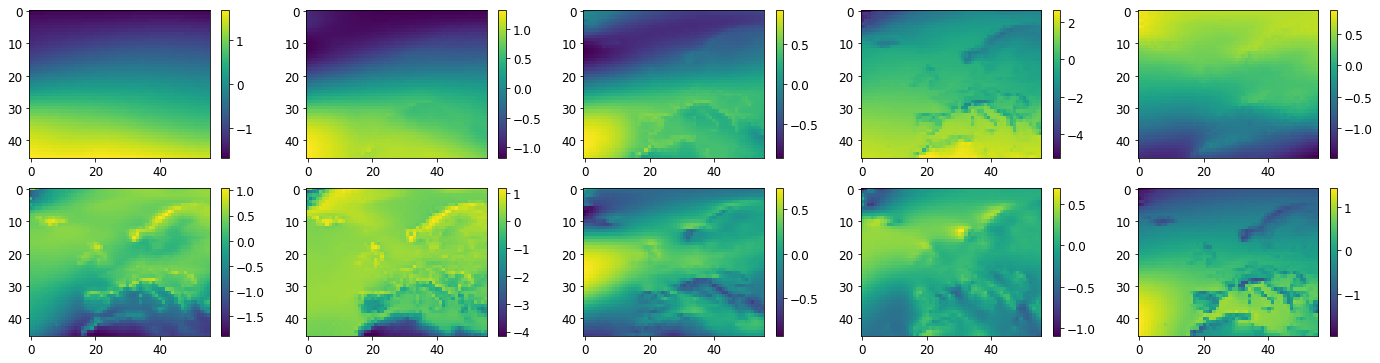

In [18]:
# checks
n_figs = len(dg_train.data[0,0,0,:])
ncols = 5
nrows = -(-n_figs // ncols)
fig, axes = plt.subplots(figsize=(24, 3*nrows), ncols=ncols, nrows=nrows)
for i in range(n_figs):
    i_row = i // ncols
    i_col = i % ncols
    im = axes[i_row, i_col].imshow(np.mean(dg_train.data[:,:,:,i], axis=0))
    fig.colorbar(im, ax=axes[i_row, i_col])

In [19]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

# U-Net architecture

In [20]:
# Define args for the U-net model
i_shape = dg_train.data.shape[1:]
o_shape = dg_train.labels.shape[1:]

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')
output_channels = 1
num_filters = 16
use_batchnorm = True
dropout = True
lr = 0.0004
optimizer = tf.optimizers.Adam(learning_rate = lr)
EPOCHS = 20
# Note: for U-net the input and output must be power of 2 ..
# I will re-define the input for an easier implementation

X shape: (46, 56, 10)
y shape: (46, 56)


In [21]:
METRICS = [
    tf.metrics.CategoricalAccuracy(name='accuracy'),
    tf.metrics.Precision(class_id = 1, name='precision'),
    tf.metrics.Recall(class_id = 1, name='recall')
]

2022-03-02 11:49:00.955428: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 11:49:01.676575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10411 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [22]:
weights = class_weight.compute_class_weight('balanced', classes = np.unique(dg_train.labels), y = np.array(dg_train.labels).flatten())

In [23]:
model_loss = weighted_binary_cross_entropy(weights = {0: weights[0].astype('float32'), 1: weights[1].astype('float32')})

In [24]:
u_mod = Unet2(i_shape, o_shape, output_channels, num_filters, use_batchnorm, dropout)

In [25]:
# Build the model and compile
um = u_mod.build_model()
um.compile(optimizer =optimizer, loss = model_loss , metrics = METRICS)

In [26]:
um.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 46, 56, 10)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 48, 64, 10)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 48, 64, 32)   2912        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 64, 32)  128         ['conv2d[0][0]']             

In [27]:
h_unet = um.fit(dg_train, epochs=EPOCHS, validation_data= dg_val)

Epoch 1/20


2022-03-02 11:49:09.836506: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


155/155 [==============================] - 18s 77ms/step - loss: 0.3502 - accuracy: 0.0817 - precision: 0.1795 - recall: 0.8943 - val_loss: 0.3182 - val_accuracy: 0.1131 - val_precision: 0.3181 - val_recall: 0.8312
Epoch 2/20
155/155 [==============================] - 11s 71ms/step - loss: 0.2674 - accuracy: 0.0979 - precision: 0.2416 - recall: 0.9262 - val_loss: 0.2925 - val_accuracy: 0.1135 - val_precision: 0.3400 - val_recall: 0.8469
Epoch 3/20
155/155 [==============================] - 11s 71ms/step - loss: 0.2489 - accuracy: 0.1033 - precision: 0.2573 - recall: 0.9319 - val_loss: 0.2493 - val_accuracy: 0.1132 - val_precision: 0.3636 - val_recall: 0.8748
Epoch 4/20
155/155 [==============================] - 11s 71ms/step - loss: 0.2362 - accuracy: 0.1092 - precision: 0.2673 - recall: 0.9377 - val_loss: 0.2448 - val_accuracy: 0.1195 - val_precision: 0.3334 - val_recall: 0.9049
Epoch 5/20
155/155 [==============================] - 11s 70ms/step - loss: 0.2270 - accuracy: 0.1095 - pre

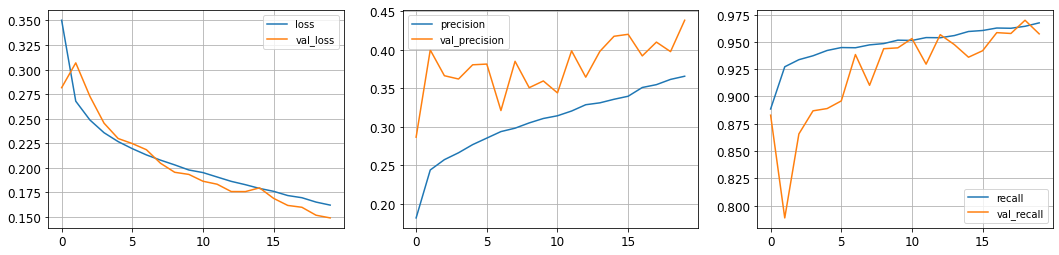

In [28]:
figure, axis = plt.subplots(1, 3)

# For Sine Function
pd.DataFrame(h_unet.history)[['loss','val_loss']].plot(figsize=(18,4), ax=axis[0], grid=True)
pd.DataFrame(h_unet.history)[['precision','val_precision']].plot(figsize=(18,4), ax=axis[1],grid=True)
pd.DataFrame(h_unet.history)[['recall','val_recall']].plot(figsize=(18,4), ax=axis[2],grid=True)
plt.show()



In [29]:
# make predictions
pred = um.predict(dg_test.data)

In [30]:
pred= pred.reshape(pred.shape[0],pred.shape[1],pred.shape[2])

In [31]:
rmse = compute_weighted_rmse(dg_test.labels,pred) #OK, I need to check this out..

In [32]:
rmse

<xarray.DataArray ()>
array(0.23679858)
Coordinates:
    quantile  float64 0.95

### ResNet 

In [ ]:
m_res = Adapted_resnet(i_shape) # not working..need to check if makes sense..

In [ ]:
m_res.compile(optimizer = optimizer, loss = model_loss , metrics = METRICS)

In [ ]:
h_res = m_res.fit(dg_train, epochs=EPOCHS, validation_data= dg_val)

### More model architectures

#### 1. Pan et al. 2019 (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR024090)

In [157]:
pad = 'valid'
stride_factor=4
# Our shapes
# output_size = [46,56,1]
# original inputs from the paper to reproduce fig.4
i_shape = [25,25,4]
output_size = [25,25,1]

In [158]:
inputs = layers.Input(shape=i_shape)
x = layers.Conv2D(15, 4, strides=(1,1), padding = pad)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(20, 4, strides=(1,1), padding = pad)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(20, 4, strides=(1,1), padding = pad)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(60)(x)
x = layers.Dense(1)(x)
x = layers.Activation('relu')(x)

# bottleneck for the upscalling part
next_shape = output_size.copy()
next_shape[0] = int(np.ceil(next_shape[0]/stride_factor))
next_shape[1] = int(np.ceil(next_shape[1]/stride_factor))

x = layers.Dense(np.prod(next_size), activation='relu')(x)
x = layers.Reshape(target_shape=next_size)(x)
x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding='same', activation='softmax')(x)
outputs = crop_output(inputs,x)

model = keras.Model(inputs, outputs, name="Pan-2019")

In [159]:
model.summary()

Model: "Pan-2019"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 25, 25, 4)]       0         
                                                                 
 conv2d_76 (Conv2D)          (None, 22, 22, 15)        975       
                                                                 
 batch_normalization_44 (Bat  (None, 22, 22, 15)       60        
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 22, 22, 15)        0         
                                                                 
 conv2d_77 (Conv2D)          (None, 19, 19, 20)        4820      
                                                                 
 batch_normalization_45 (Bat  (None, 19, 19, 20)       80        
 chNormalization)                                         

#### 2. Shi2020 (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL090309)

In [292]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, SeparableConvolution2D

#### 2.1. RaNet

In [293]:
# In this case using conv3D the input has to be 4D tensor, so it is splitted in lev, lat,lon, var
#i_shape = [3, 46, 56,7]
i_shape = [6, 12, 12, 5]

In [294]:
inputs = layers.Input(shape=i_shape)
x = layers.Conv3D(128, kernel_size=(3, 3, 3),padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling3D()(x)
x = layers.Conv3D(256, kernel_size=(3, 3, 3),padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling3D()(x)
x = layers.Conv3D(512, kernel_size=(3, 3, 3),padding="same")(x)

x = layers.GlobalAveragePooling3D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
#---------note: we can skip the 3-last fully connected layers to add the upscalling part
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='relu')(x)
outputs = layers.Dropout(0.2)(x)
model = keras.Model(inputs, outputs, name="RaNet")

In [274]:
model.summary()

Model: "RaNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 6, 12, 12, 5)]    0         
                                                                 
 conv3d_78 (Conv3D)          (None, 6, 12, 12, 128)    17408     
                                                                 
 batch_normalization_118 (Ba  (None, 6, 12, 12, 128)   512       
 tchNormalization)                                               
                                                                 
 activation_111 (Activation)  (None, 6, 12, 12, 128)   0         
                                                                 
 max_pooling3d_55 (MaxPoolin  (None, 3, 6, 6, 128)     0         
 g3D)                                                            
                                                                 
 conv3d_79 (Conv3D)          (None, 3, 6, 6, 256)      884992

#### 2.2. RxNet

In [290]:
# RxNet 
# Original input_size
i_shape = [12,12,30]
inputs = layers.Input(shape=i_shape)
x = layers.Conv2D(128, (3,3), strides = (2,2), padding='same')(inputs)
x = layers.Activation('relu')(x)
x = layers.Conv2D(516, (3,3), padding='same' )(x)
x = layers.Activation('relu')(x)
x

<KerasTensor: shape=(None, 6, 6, 516) dtype=float32 (created by layer 'activation_132')>

In [291]:
x = layers.SeparableConv2D(512, (3,3), padding='same', )(x)
x = layers.SeparableConv2D(512, (3,3), padding='same', )(x)
x


<KerasTensor: shape=(None, 6, 6, 512) dtype=float32 (created by layer 'separable_conv2d_3')>